# Model 2: Credit Card Over Limit

**Imports:**

In [43]:
%reload_ext autoreload
%autoreload 1
from pprint import pprint
import polars as pl
import shap
from sklearn.pipeline import Pipeline
import auxiliary.transformers as tr
import auxiliary.eda_functions as eda
from auxiliary.transformers import PolarsColumnTransformer as PCT
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import copy
import seaborn as sns
import auxiliary.tuning as tunes
from ray import tune
import joblib
import numpy as np
from BorutaShap import BorutaShap
import matplotlib.pyplot as plt
%aimport auxiliary.eda_functions
%aimport auxiliary.transformers
%aimport auxiliary.tuning

**Data Imports and Splitting:**

In [2]:
data = pl.read_parquet("temp/active_credit_cards.parquet")
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns="IS_OVER_LIMIT"),
    data["IS_OVER_LIMIT"],
    test_size=0.3,
    stratify=data["IS_OVER_LIMIT"],
    random_state=1,
)

## Pipeline Construction

**Specifying feature types:**

In [3]:
bool_features = []
for feature in X_train.select(pl.col(pl.Utf8)).columns:
    if X_train[feature].n_unique() == 2:
        bool_features.append(feature)

cat_features = [
    feature
    for feature in X_train.select(pl.col(pl.Utf8)).columns
    if feature not in bool_features
]

numeric_features_with_nulls = (
    pl.Series(
        X_train.select(pl.col(pl.FLOAT_DTYPES), pl.col(pl.INTEGER_DTYPES)).columns
    )
    .filter(
        X_train.select(pl.col(pl.FLOAT_DTYPES), pl.col(pl.INTEGER_DTYPES))
        .select(pl.all().is_null().any())
        .transpose()
        .to_series()
    )
    .to_list()
)

**Preprocessing pipeline:**

In [4]:
preprocessing = Pipeline([])
cat_imputers = tr.PolarsColumnTransformer([])
for feature in cat_features:
    cat_imputers.steps[feature] = PCT.Step(
        feature, tr.NotInImputerPolars(min_values=100, fill_value="other"), feature
    )
preprocessing.steps.append(("cat_imputers", cat_imputers))

encoders = tr.PolarsColumnTransformer([])
for feature in bool_features:
    encoders.steps[feature] = PCT.Step(
        feature, tr.PolarsOneHotEncoder(drop=True), feature
    )
for feature in cat_features:
    encoders.steps[feature] = PCT.Step(
        feature, tr.TargetMeanOrderedLabeler(how="label"), feature
    )

preprocessing.steps.append(("encoders", encoders))

scaler = tr.PolarsColumnTransformer(
    [
        PCT.Step(
            "scaler",
            MinMaxScaler(),
            preprocessing.fit_transform(X_train, y_train).columns,
        )
    ]
)

preprocessing.steps.append(("scaler", scaler))
preprocessing.steps.append(("null_imputer", tr.PolarsNullImputer(-1)))

feature_remover = tr.FeatureRemover([])
preprocessing.steps.append(("feature_removal", feature_remover))

**Model and Oversampling:**

In [5]:
model_lgb = LGBMClassifier(n_jobs=1, verbosity=-1)
sampler_model = tr.SamplingModelWrapper(model_lgb)
full_pipeline = Pipeline([("preprocess", preprocessing), ("model", sampler_model)])

## Feature Selection

**Running Boruta SHAP with different strictness and saving lists of bad features:**

In [6]:
feature_removal_list = []
for i in [20, 40, 60, 80, 100]:
    model_for_selection_high_reg = LGBMClassifier(
        verbose=-1, random_state=1, num_leaves=100
    )
    selector = BorutaShap(
        importance_measure="shap", model=model_for_selection_high_reg, percentile=i
    )
    selector.fit(
        full_pipeline["preprocess"].fit_transform(X_train, y_train).to_pandas(),
        y_train.to_pandas(),
    )
    feature_removal_list.append(copy.deepcopy(selector.features_to_remove.tolist()))
joblib.dump(feature_removal_list, "temp/model_2_feature_removal.joblib")

  0%|          | 0/20 [00:00<?, ?it/s]

43 attributes confirmed important: ['HISTORIC_IS_OVER_LIMIT_mean', 'NAME_FAMILY_STATUS', 'instalment_AMT_UNDERPAID_max', 'CODE_GENDER_F', 'APPLICATION_AMT_APPLICATION', 'ORGANIZATION_TYPE', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'CNT_INSTALMENT_MATURE_CUM', 'HISTORIC_OVER_LIMIT_std', 'APPLICATION_AMT_CREDIT', 'APPLICATION_HOUR_APPR_PROCESS_START', 'FLAG_OWN_REALTY_N', 'CNT_FAM_MEMBERS', 'OCCUPATION_TYPE', 'HISTORIC_OVER_LIMIT_mean', 'HISTORIC_IS_OVER_LIMIT_std', 'instalment_AMT_UNDERPAID_sum', 'instalment_DAYS_LATE_mean', 'SK_DPD_DEF', 'APPLICATION_NAME_SELLER_INDUSTRY', 'HISTORIC_IS_OVER_LIMIT_sum', 'HISTORIC_OVER_LIMIT_sum', 'NAME_INCOME_TYPE', 'AMT_INST_MIN_REGULARITY', 'instalment_AMT_UNDERPAID_mean', 'APPLICATION_NAME_TYPE_SUITE', 'APPLICATION_CHANNEL_TYPE', 'HISTORIC_OVER_LIMIT_max', 'DAYS_EMPLOYED', 'weekday_sin', 'OWN_CAR_AGE', 'APPLICATION_NAME_PRODUCT_TYPE', 'AMT_CREDIT_LIMIT_ACTUAL', 'weekday_cos', 'instalment_DAYS_LATE_max', 'instalment_DAYS_LATE_sum', 'HISTORIC_NUM_ENTRIES', 'S

  0%|          | 0/20 [00:00<?, ?it/s]

32 attributes confirmed important: ['HISTORIC_IS_OVER_LIMIT_mean', 'APPLICATION_AMT_APPLICATION', 'ORGANIZATION_TYPE', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'CNT_INSTALMENT_MATURE_CUM', 'HISTORIC_OVER_LIMIT_std', 'APPLICATION_AMT_CREDIT', 'APPLICATION_HOUR_APPR_PROCESS_START', 'OCCUPATION_TYPE', 'HISTORIC_OVER_LIMIT_mean', 'HISTORIC_IS_OVER_LIMIT_std', 'instalment_DAYS_LATE_mean', 'HISTORIC_IS_OVER_LIMIT_sum', 'HISTORIC_OVER_LIMIT_sum', 'AMT_INST_MIN_REGULARITY', 'instalment_AMT_UNDERPAID_mean', 'APPLICATION_NAME_TYPE_SUITE', 'APPLICATION_CHANNEL_TYPE', 'HISTORIC_OVER_LIMIT_max', 'DAYS_EMPLOYED', 'weekday_sin', 'OWN_CAR_AGE', 'AMT_CREDIT_LIMIT_ACTUAL', 'weekday_cos', 'instalment_DAYS_LATE_max', 'instalment_DAYS_LATE_sum', 'HISTORIC_NUM_ENTRIES', 'SK_DPD', 'REGION_POPULATION_RELATIVE', 'APPLICATION_AMT_ANNUITY', 'APPLICATION_SELLERPLACE_AREA']
20 attributes confirmed unimportant: ['APPLICATION_NFLAG_LAST_APPL_IN_DAY', 'REGION_RATING_CLIENT', 'APPLICATION_NFLAG_INSURED_ON_APPROVAL', 'REG_REG

  0%|          | 0/20 [00:00<?, ?it/s]

23 attributes confirmed important: ['HISTORIC_IS_OVER_LIMIT_mean', 'ORGANIZATION_TYPE', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'CNT_INSTALMENT_MATURE_CUM', 'HISTORIC_OVER_LIMIT_std', 'APPLICATION_HOUR_APPR_PROCESS_START', 'APPLICATION_AMT_CREDIT', 'HISTORIC_OVER_LIMIT_mean', 'HISTORIC_IS_OVER_LIMIT_std', 'instalment_DAYS_LATE_mean', 'HISTORIC_OVER_LIMIT_sum', 'AMT_INST_MIN_REGULARITY', 'APPLICATION_CHANNEL_TYPE', 'HISTORIC_OVER_LIMIT_max', 'DAYS_EMPLOYED', 'AMT_CREDIT_LIMIT_ACTUAL', 'instalment_DAYS_LATE_max', 'instalment_DAYS_LATE_sum', 'HISTORIC_NUM_ENTRIES', 'SK_DPD', 'REGION_POPULATION_RELATIVE', 'APPLICATION_AMT_ANNUITY']
30 attributes confirmed unimportant: ['APPLICATION_NFLAG_LAST_APPL_IN_DAY', 'REGION_RATING_CLIENT', 'APPLICATION_NFLAG_INSURED_ON_APPROVAL', 'NAME_FAMILY_STATUS', 'REG_REGION_NOT_LIVE_REGION', 'CODE_GENDER_F', 'APPLICATION_AMT_APPLICATION', 'HISTORIC_OVER_LIMIT_min', 'HISTORIC_OVER_LIMIT_mode', 'LIVE_REGION_NOT_WORK_REGION', 'CNT_CHILDREN', 'NAME_HOUSING_TYPE', 'FLAG_

  0%|          | 0/20 [00:00<?, ?it/s]

15 attributes confirmed important: ['CNT_INSTALMENT_MATURE_CUM', 'HISTORIC_OVER_LIMIT_sum', 'HISTORIC_IS_OVER_LIMIT_mean', 'HISTORIC_OVER_LIMIT_std', 'AMT_INST_MIN_REGULARITY', 'instalment_DAYS_LATE_max', 'instalment_DAYS_LATE_sum', 'HISTORIC_NUM_ENTRIES', 'HISTORIC_IS_OVER_LIMIT_std', 'SK_DPD', 'HISTORIC_OVER_LIMIT_mean', 'APPLICATION_AMT_ANNUITY', 'instalment_DAYS_LATE_mean', 'AMT_CREDIT_LIMIT_ACTUAL', 'DAYS_BIRTH']
35 attributes confirmed unimportant: ['APPLICATION_NFLAG_LAST_APPL_IN_DAY', 'REGION_RATING_CLIENT', 'APPLICATION_NFLAG_INSURED_ON_APPROVAL', 'NAME_FAMILY_STATUS', 'REG_REGION_NOT_LIVE_REGION', 'instalment_AMT_UNDERPAID_max', 'CODE_GENDER_F', 'APPLICATION_AMT_APPLICATION', 'HISTORIC_OVER_LIMIT_min', 'HISTORIC_OVER_LIMIT_mode', 'LIVE_REGION_NOT_WORK_REGION', 'CNT_CHILDREN', 'NAME_HOUSING_TYPE', 'FLAG_OWN_REALTY_N', 'APPLICATION_AMT_CREDIT', 'CNT_FAM_MEMBERS', 'OCCUPATION_TYPE', 'instalment_AMT_UNDERPAID_sum', 'SK_DPD_DEF', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',

  0%|          | 0/20 [00:00<?, ?it/s]

9 attributes confirmed important: ['CNT_INSTALMENT_MATURE_CUM', 'HISTORIC_OVER_LIMIT_sum', 'HISTORIC_IS_OVER_LIMIT_mean', 'AMT_INST_MIN_REGULARITY', 'HISTORIC_NUM_ENTRIES', 'HISTORIC_IS_OVER_LIMIT_std', 'HISTORIC_OVER_LIMIT_mean', 'APPLICATION_AMT_ANNUITY', 'AMT_CREDIT_LIMIT_ACTUAL']
47 attributes confirmed unimportant: ['APPLICATION_NFLAG_LAST_APPL_IN_DAY', 'REGION_RATING_CLIENT', 'APPLICATION_NFLAG_INSURED_ON_APPROVAL', 'NAME_FAMILY_STATUS', 'REG_REGION_NOT_LIVE_REGION', 'instalment_AMT_UNDERPAID_max', 'CODE_GENDER_F', 'APPLICATION_AMT_APPLICATION', 'HISTORIC_OVER_LIMIT_mode', 'HISTORIC_OVER_LIMIT_min', 'LIVE_REGION_NOT_WORK_REGION', 'ORGANIZATION_TYPE', 'AMT_INCOME_TOTAL', 'APPLICATION_AMT_CREDIT', 'APPLICATION_HOUR_APPR_PROCESS_START', 'CNT_CHILDREN', 'NAME_HOUSING_TYPE', 'FLAG_OWN_REALTY_N', 'CNT_FAM_MEMBERS', 'OCCUPATION_TYPE', 'instalment_AMT_UNDERPAID_sum', 'SK_DPD_DEF', 'REG_CITY_NOT_LIVE_CITY', 'APPLICATION_NAME_SELLER_INDUSTRY', 'HISTORIC_IS_OVER_LIMIT_sum', 'REG_CITY_NOT_WO

['temp/model_2_feature_removal.joblib']

**Loading the lists of features to remove:**

In [6]:
feature_removal_list = joblib.load("temp/model_2_feature_removal.joblib")

## Hyperparameter Tuning

**Hyperparameter search space:**

In [7]:
model_params_lgb = {
    "max_depth": tune.randint(5, 30),
    "num_leaves": tune.randint(10, 1000),
    "n_estimators": tune.randint(10, 251),
    "learning_rate": tune.loguniform(0.001, 0.1),
    "bagging_freq": tune.randint(0, 11),
    "colsample_bytree": tune.uniform(0.2, 1.0),
    "subsample": tune.uniform(0.2, 1.0),
    "reg_alpha": tune.loguniform(0.001, 100),
    "reg_lambda": tune.loguniform(0.001, 100),
    "boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "class_weight": tune.choice(["balanced", None]),
    "max_bin": tune.randint(5, 201),
}

search_space_lgbm = {
    "preprocess__feature_removal__feats_to_drop": tune.choice(feature_removal_list),
    "model__model_params": model_params_lgb,
    "model__sampler": tune.choice(["random", "smote", "adasyn", None]),
}

model = tunes.Models.Model(
    "lgbm",
    full_pipeline,
    search_space_lgbm,
)

**Hyperparameter tuning:**

In [ ]:
model = joblib.load("temp/model_2_tuned_model.joblib")

**Best Parameters:**

In [15]:
for key, param in model.best_params.items():
    if key[:3] == "mod":
        pprint(key + ":")
        pprint(param)

'model__model_params:'
{'bagging_freq': 10,
 'boosting_type': 'dart',
 'class_weight': 'balanced',
 'colsample_bytree': 0.6569932922749475,
 'learning_rate': 0.009137071978349154,
 'max_bin': 184,
 'max_depth': 19,
 'n_estimators': 14,
 'num_leaves': 471,
 'reg_alpha': 40.469518129301555,
 'reg_lambda': 0.025719425031357383,
 'subsample': 0.7206896791440347}
'model__sampler:'
'adasyn'


**Number of features removed:**

In [16]:
len(model.best_params["preprocess__feature_removal__feats_to_drop"])

35

The optimal parameters for the DART algorithm included a slow learning rate of 0.09, a leaf limit of 471, a very high alpha regularization, and a modest number of estimators (14). Additionally, balanced class weights and ADASYN oversampling were identified as the best options. During the tuning process, 35 features were determined to be removed.

## Model Testing

In [23]:
model.pipeline.fit(X_train, y_train)
predictions = model.pipeline.predict(X_test)
predictions_proba = model.pipeline.predict_proba(X_test)[:, 1]
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     14805
           1       0.63      0.62      0.63      2260

    accuracy                           0.90     17065
   macro avg       0.79      0.78      0.78     17065
weighted avg       0.90      0.90      0.90     17065



The model achieved an F-1 Score of 0.63 for the positive class, surpassing the dummy baseline of 0.134, despite the positive class constituting only 15% of the samples. This indicates a notable improvement in predicting the positive class compared to a simplistic baseline.

** Receiver operating characteristic curve:**

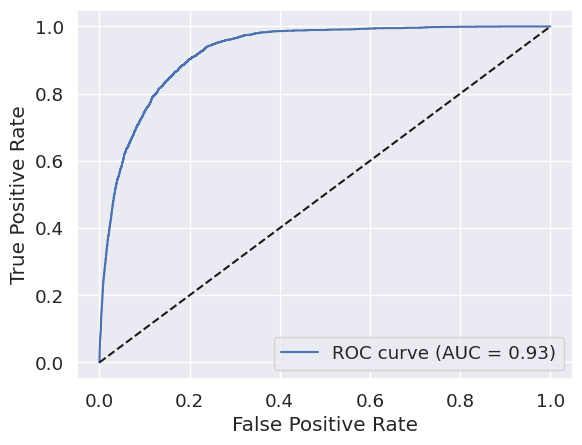

In [42]:
eda.plot_roc_curve(y_test, predictions_proba)
plt.show()

**Confusion Matrix:**

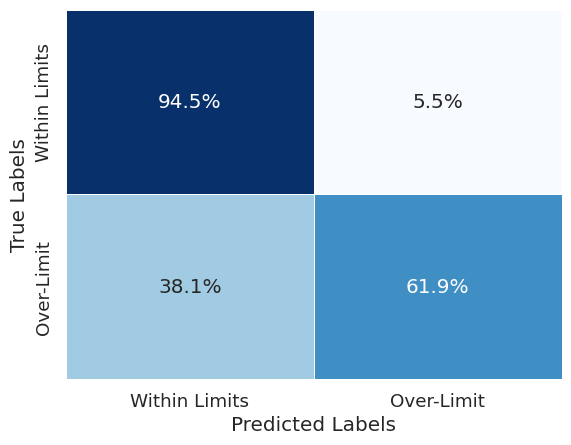

In [52]:
confusion = confusion_matrix(y_test, predictions, normalize="true")
joblib.dump(confusion, "summary_data/model2_confusion.joblib")
class_labels = ["Within Limits", "Over-Limit"]

sns.heatmap(
    confusion,
    annot=True,
    fmt=".1%",
    cmap="Blues",
    linewidths=0.5,
    cbar=False,
    xticklabels=class_labels,
    yticklabels=class_labels,
)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Feature Importance

**SHAP value calculation and bee swarm plot:**

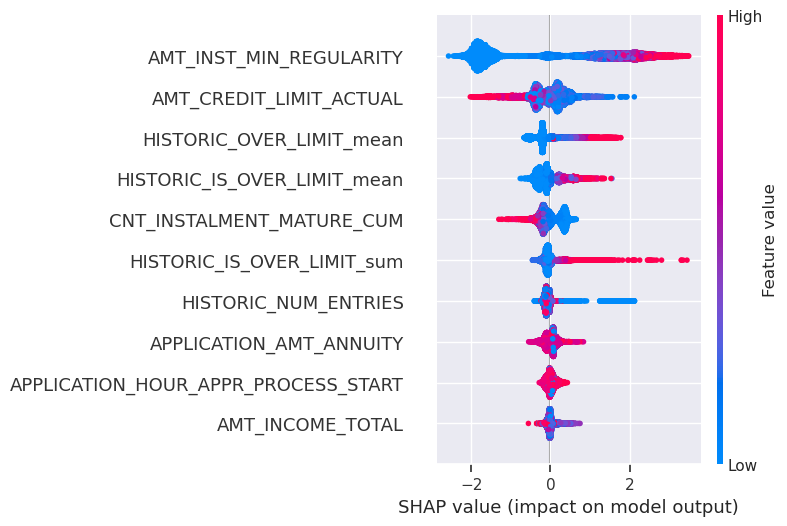

In [51]:
sample_data = model.pipeline["preprocess"].transform(X_test)

explainer_tree = shap.TreeExplainer(
    model.pipeline["model"].model, data=sample_data.to_numpy()
)

shap_values = explainer_tree(sample_data.to_numpy())

joblib.dump(
    {
        "sample_data": sample_data,
        "shap_vales": shap_values,
        "names": sample_data.columns,
    },
    "summary_data/shap_model2.joblib",
)

shap.summary_plot(
    shap_values,
    sample_data.to_numpy(),
    feature_names=sample_data.columns,
    max_display=10,
)

Shap value analysis revealed that the most valuable features for the model included installment size, credit limit, the fraction of time the cardholder went over the limit, the sum and mean of the amount over the limit, the number of paid installments previously, credit card history length (historic_num_entries), annuity, and the total income of the credit card holder. These features played a significant role in influencing the model's predictions for credit card behavior.

## Model Summary

* The best performing pipeline included:
    1. Removal of 35 features leaving 26.
    2. ADASYN Oversampling.
    3. LightGBM model with DART algorithm, 14 estimators, leaf limit of 471, and a low learning rate of 0.009.
* The model achieved an F-1 Score of 0.63 beating the baseline.
* The most valuable features included values related to the amount of the loan itself and historic financial discipline of the card holder.